<a href="https://colab.research.google.com/github/iii719/GUI_PEIA/blob/master/%ED%94%BC%EC%95%84_label_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
cd "/content/drive/MyDrive//peia"

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from skimage.transform import resize
import pickle
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

liked와 disliked중 하나만 체크한 데이터만 사용

In [6]:
data = pd.read_csv('data.csv')
se_filtered_data = data[data[' liked'] != data[' disliked']]
se_filtered_data.to_csv('/content/drive/MyDrive/peia/se_filtered_data.csv', index=False)

<ipython-input-6-04880d9fdd32>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se_filtered_data[' liked'] = se_filtered_data[' liked'] - se_filtered_data[' disliked']


In [7]:
data = pd.read_csv('se_filtered_data.csv')

def to_tensor(df, column, dtype=torch.float):
    return torch.tensor(df[column].values, dtype=dtype)

#user_data
user_info_columns = [' age', ' gender']
le = LabelEncoder()
data[' mother tongue'] = le.fit_transform(data[' mother tongue'])
user = {col.lstrip(): to_tensor(data, col) for col in user_info_columns}
user['mother tongue'] = torch.tensor(data[' mother tongue'].values, dtype=torch.long)

#mood_data
current_mood_column = [' mood']
mood = {col.lstrip(): to_tensor(data, col) for col in current_mood_column}

#emotion_data
emotion_columns = [' amazement', ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power', ' joyful_activation', ' tension', ' sadness']
emotion = {col.lstrip(): to_tensor(data, col) for col in emotion_columns}

#preference_data
liked = to_tensor(data, ' liked')
preference = {'pref':liked }

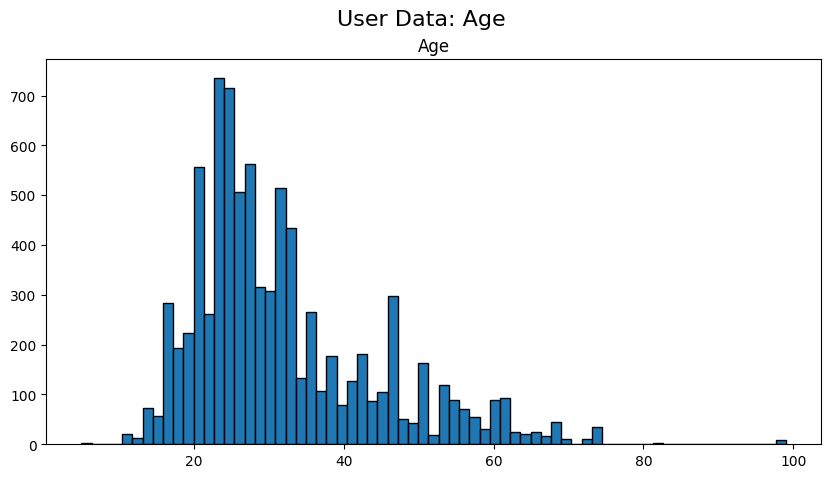

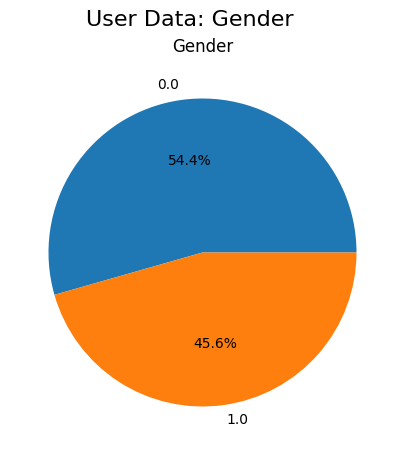

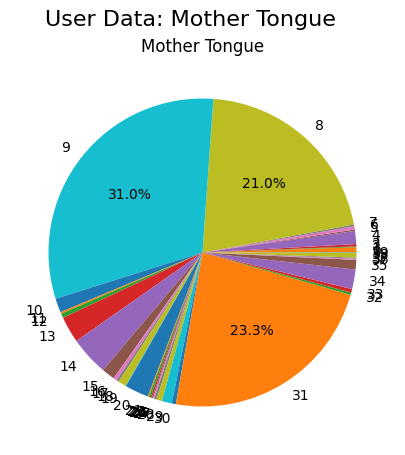

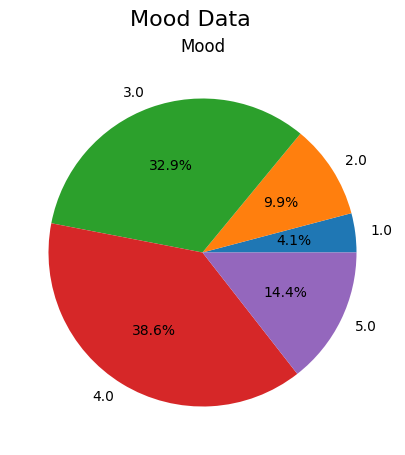

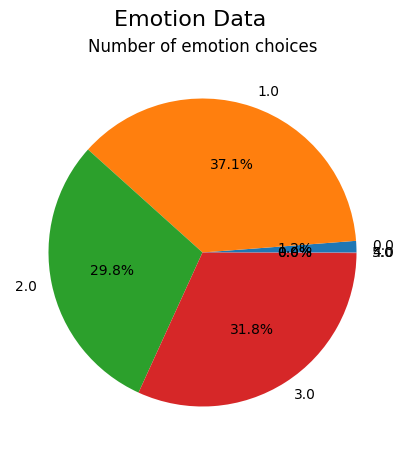

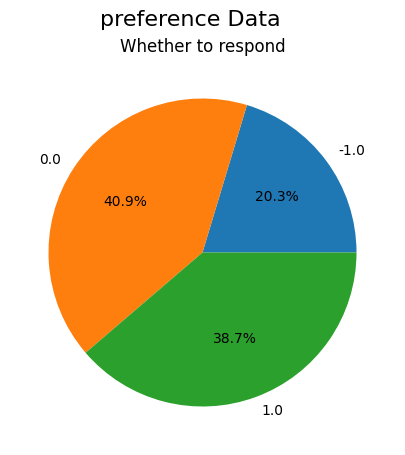

In [8]:
def plot_dict(data_dict, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)

    if title == 'User Data: Age':
        ax.hist(data_dict['age'].numpy(), bins='auto', edgecolor='black')
        ax.set_title('Age')

    elif title == 'User Data: Gender':
        unique_elements, counts = torch.unique(data_dict['gender'], return_counts=True)
        ax.pie(counts, labels=unique_elements.numpy(), autopct='%1.1f%%')
        ax.set_title('Gender')

    elif title == 'User Data: Mother Tongue':
        unique_elements, counts = torch.unique(data_dict['mother tongue'], return_counts=True)
        sorted_indices = torch.argsort(counts, descending=True)
        counts_top3 = counts[sorted_indices[:3]]
        labels = unique_elements.numpy()
        labels_top3 = labels[sorted_indices[:3]]
        labels_other = labels[sorted_indices[3:]]
        ax.pie(counts, labels=labels, autopct=lambda pct: f'{pct:.1f}%' if pct in (counts_top3 / counts.sum()) * 100 else '')
        ax.set_title('Mother Tongue')

    elif title == 'Mood Data':
        unique_elements, counts = torch.unique(data_dict['mood'], return_counts=True)
        ax.pie(counts, labels=unique_elements.numpy(), autopct='%1.1f%%')
        ax.set_title('Mood')

    elif title == 'Emotion Data':
        total = torch.stack(list(data_dict.values())).sum(dim=0)
        unique_elements, counts = torch.unique(total, return_counts=True)
        ax.pie(counts, labels=unique_elements.numpy(), autopct='%1.1f%%')
        ax.set_title('Number of emotion choices')

    elif title == 'preference Data':
        total = torch.stack(list(data_dict.values())).sum(dim=0)
        unique_elements, counts = torch.unique(total, return_counts=True)
        ax.pie(counts, labels=unique_elements.numpy(), autopct='%1.1f%%')
        ax.set_title('Whether to respond')

    plt.show()

plot_dict(user, 'User Data: Age')
plot_dict(user, 'User Data: Gender')
plot_dict(user, 'User Data: Mother Tongue')
plot_dict(mood, 'Mood Data')
plot_dict(emotion, 'Emotion Data')
plot_dict(preference, 'preference Data')

모든 데이터를 device로 보내고 data info 표시

In [9]:
user = {key: values.to(device) for key, values in user.items()}
mood = {key: values.to(device) for key, values in mood.items()}
emotion = {key: values.to(device) for key, values in emotion.items()}
preference = {key: values.to(device) for key, values in preference.items()}

def print_info(data_dict, title):
    print(f"Information for {title} data:")
    for key, values in data_dict.items():
        print(f"For key {key}: Shape: {values.shape},Type: {values.dtype}, Device: {values.device}:")
    print()

print_info(user, 'User')
print_info(mood, 'Mood')
print_info(emotion, 'Emotion')
print_info(preference, 'preference')

Information for User data:
For key age: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key gender: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key mother tongue: Shape: torch.Size([8348]),Type: torch.int64, Device: cuda:0:

Information for Mood data:
For key mood: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:

Information for Emotion data:
For key amazement: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key solemnity: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key tenderness: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key nostalgia: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key calmness: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key power: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key joyful_activation: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key tension: Sha

스펙토그램 추출해서 저장

In [ ]:
# genres = ['classical', 'rock', 'pop', 'electronic' ]
# music_files = {genre: [] for genre in genres}

# for genre in genres:
#     for file in os.listdir(f'/content/drive/MyDrive/peia/spect_files/{genre}'):
#         if file.endswith('.npy'):
#             spect = np.load(f'/content/drive/MyDrive/spect_files/{genre}/{file}')
#             spect = (spect - spect.min()) / (spect.max() - spect.min())
#             resized_spect = resize(spect, (128, 128))
#             tensor_spect = torch.tensor(resized_spect, dtype=torch.float)
#             music_files[genre].append(tensor_spect)

# torch.save(music_files, '/content/drive/MyDrive/peia/spect_files/music_files.pt')

이미 추출한 스펙토그램을 로드

각 스펙토그램을 dataset에 맞게 적절히 복제

In [10]:
# Load the tensor with `torch.load`
genres = ['classical', 'rock', 'pop', 'electronic' ]
music_files = torch.load('/content/drive/MyDrive/peia/spect_files/music_files.pt')

combined_spectograms = []
for idx in data['track id'].values:
  genre_idx = (idx - 1) // 100
  file_idx = (idx - 1) % 100
  combined_spectograms.append(music_files[genres[genre_idx]][file_idx])
combined_spectograms = torch.stack(combined_spectograms).to(device)
Spectogram = {'spectogram': combined_spectograms}

Custom dataset for spectogram's dimsion reduction

In [11]:
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data['spectogram']

    def __getitem__(self, index):
        return self.data[index].unsqueeze(0)

    def __len__(self):
        return len(self.data)

스펙톡그램의 차원 (8348,128,128) ->(8348,2)

시간과 주파수의 domain이니까 2차원으로 충분

In [12]:
class aE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*29*29, 16*29),
            nn.ReLU(),
            nn.Linear(16*29, 2)
        )

        self.decoder = nn.Sequential(
          nn.Linear(2, 16*29),
          nn.ReLU(),
          nn.Linear(16*29, 32*29*29),
          nn.ReLU(),
          nn.Unflatten(1, (32, 29, 29)),
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 8, kernel_size=5),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
          nn.ConvTranspose2d(8, 1, kernel_size=5),
          nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat,z

In [13]:
AE = aE().to(device)

learning_rate = 1e-3
weight_decay = 0.01

optimizer_AE = torch.optim.Adam(AE.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler_AE = torch.optim.lr_scheduler.StepLR(optimizer_AE, step_size=30, gamma=0.1)


def loss_function_AE(x_hat, x):
    BCE = nn.functional.binary_cross_entropy(
        x_hat.view(-1, 128*128), x.view(-1, 128*128), reduction='sum'
    )

    return BCE

In [14]:
dataset = SpectrogramDataset(Spectogram)
batch_size = 16

num_train = int(len(dataset) * 0.8)
num_val = len(dataset) - num_train

train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

학습

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):

    AE.train()
    train_loss_AE = 0
    for x in train_loader:
        optimizer_AE.zero_grad()
        x_hat,_ = AE(x)
        loss = loss_function_AE(x_hat, x)
        loss.backward()
        optimizer_AE.step()
        train_loss_AE += loss.item()
    train_loss_AE /= len(train_loader)

    AE.eval()
    val_loss_AE = 0
    with torch.no_grad():
        for x in val_loader:
            x_hat,_ = AE(x)
            loss = loss_function_AE(x_hat, x)
            val_loss_AE += loss.item()
        val_loss_AE /= len(val_loader)

    print(f"Epoch: {epoch}, Train Loss: {train_loss_AE:.3f}, Val Loss: {val_loss_AE:.3f}")

torch.save(AE.state_dict(), "AE_params.pth")

Epoch: 0, Train Loss: 4058.591, Val Loss: 4109.718
Epoch: 1, Train Loss: 4047.453, Val Loss: 4106.751
Epoch: 2, Train Loss: 4046.818, Val Loss: 4102.538
Epoch: 3, Train Loss: 4043.679, Val Loss: 4113.929
Epoch: 4, Train Loss: 4043.465, Val Loss: 4102.838
Epoch: 5, Train Loss: 4041.159, Val Loss: 4104.698
Epoch: 6, Train Loss: 4036.696, Val Loss: 4101.408
Epoch: 7, Train Loss: 4037.551, Val Loss: 4096.851
Epoch: 8, Train Loss: 4034.787, Val Loss: 4096.378
Epoch: 9, Train Loss: 4033.602, Val Loss: 4095.864
Epoch: 10, Train Loss: 4032.278, Val Loss: 4109.117
Epoch: 11, Train Loss: 4031.022, Val Loss: 4089.095
Epoch: 12, Train Loss: 4027.203, Val Loss: 4095.472
Epoch: 13, Train Loss: 4026.855, Val Loss: 4086.502
Epoch: 14, Train Loss: 4026.553, Val Loss: 4087.409
Epoch: 15, Train Loss: 4021.863, Val Loss: 4093.787
Epoch: 16, Train Loss: 4023.852, Val Loss: 4088.045
Epoch: 17, Train Loss: 4024.820, Val Loss: 4079.909
Epoch: 18, Train Loss: 4017.458, Val Loss: 4082.239
Epoch: 19, Train Loss:

In [15]:
AE.load_state_dict(torch.load("AE_params.pth"))
dataset = SpectrogramDataset(Spectogram)
input_loader = DataLoader(dataset, batch_size=32, shuffle=False)

transformed_data = []

AE.eval().to(device)

with torch.no_grad():
    for inputs in input_loader:
        x_hat, transformed_batch = AE(inputs.to(device))

        transformed_data.append(transformed_batch)

transformed_data = torch.cat(transformed_data, dim=0)
transformed_data1 = transformed_data[:, 0]
transformed_data2 = transformed_data[:, 1]

4930X2의 shape을 4930짜리 두개로 쪼개서 dataset shape 통일

In [16]:
Genre = {}
Genre['genre1'] = transformed_data1
Genre['genre2'] = transformed_data2
print_info(Genre, 'Genre')

Information for Genre data:
For key genre1: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:
For key genre2: Shape: torch.Size([8348]),Type: torch.float32, Device: cuda:0:



현재 400곡에 대한 스펙토그램을 장르별 추출

추후 곡 추가시 재활용

In [ ]:
genre_song_count = {}

genre_dirs = ['classical', 'rock', 'pop', 'electronic']

for genre in genre_dirs:
    files_in_dir = os.listdir(f'emotifymusic/{genre}')
    files_in_dir = [int(os.path.splitext(file)[0]) for file in files_in_dir]
    files_in_dir = sorted(files_in_dir)
    last_file = files_in_dir[-1]
    genre_song_count[genre] = last_file

music_files에 대한 데이터셋 커스텀

In [ ]:
class MultiSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.genres = list(data.keys())
        self.lengths = [len(data[genre]) for genre in self.genres]
        self.total_length = sum(self.lengths)

    def __getitem__(self, index):
        for i, length in enumerate(self.lengths):
            if index < length:
                return self.data[self.genres[i]][index].unsqueeze(0)
            else:
                index -= length

    def __len__(self):
        return self.total_length


music_files에 대한 AE

In [ ]:
music_files_dataset = MultiSpectrogramDataset(music_files)
input_loader = DataLoader(music_files_dataset, batch_size=16, shuffle=False)

transformed_data = []
AE.eval().to(device)
with torch.no_grad():
    for inputs in input_loader:
        x_hat, transformed_batch = AE(inputs.to(device))
        transformed_data.append(transformed_batch)

transformed_data = torch.cat(transformed_data, dim=0)

Genres = {genre: [] for genre in music_files.keys()}
for i, genre in enumerate(music_files_dataset.genres):
    Genres[genre] = transformed_data[sum(music_files_dataset.lengths[:i]):sum(music_files_dataset.lengths[:i+1])]

In [ ]:
for genre, data in Genres.items():
    print(f'Genre: {genre}')
    print(f'Number of items: {len(data)}')
    print(f'Data type: {type(data)}')
    print(f'Shape of the data: {data.shape}')
    print('-------------------------')

Genre: classical
Number of items: 100
Data type: <class 'torch.Tensor'>
Shape of the data: torch.Size([100, 2])
-------------------------
Genre: rock
Number of items: 100
Data type: <class 'torch.Tensor'>
Shape of the data: torch.Size([100, 2])
-------------------------
Genre: pop
Number of items: 100
Data type: <class 'torch.Tensor'>
Shape of the data: torch.Size([100, 2])
-------------------------
Genre: electronic
Number of items: 100
Data type: <class 'torch.Tensor'>
Shape of the data: torch.Size([100, 2])
-------------------------


In [ ]:
save_dir = 'spected_music'
os.makedirs(save_dir, exist_ok=True)
for genre, data in Genres.items():
    torch.save(data, os.path.join(save_dir, f'{genre}_data.pt'))

In [ ]:
total_spected = torch.cat([data for vdata in Genres.values()], dim=0)

각 곡에 대해 상위 5개를 매핑해주는 딕셔너리(장르 불문)

뒤에 소수점은 장르 판단을 위한 표시

.0 = classical

.1 = rock

.2 = pop

.3 = electronic

음량은 유사도와 상관없다고 판단, 방향만 고려하는 cosine_similarity 사용

In [ ]:
classical_top_5_similar={}
rock_top_5_similar={}
pop_top_5_similar={}
electronic_top_5_similar={}

classical_start = 0
rock_start = classical_start + genre_song_count['classical']
pop_start = rock_start + genre_song_count['rock']
electronic_start = pop_start+genre_song_count['pop']

for i in range(total_spected.shape[0]):
    song = total_spected[i]
    similarities = f.cosine_similarity(song, total_spected)
    similarities[i] = -2
    top_5 = similarities.argsort(descending=True)[:5].tolist()
    for j in range(len(top_5)):
      if top_5[j] < rock_start:
        top_5[j] = top_5[j]+0.0-classical_start
      elif top_5[j] < pop_start:
        top_5[j] = top_5[j]+0.1-rock_start
      elif top_5[j] < electronic_start:
        top_5[j] = top_5[j]+0.2-pop_start
      else:
        top_5[j] = top_5[j]+0.3-electronic_start

    if i<rock_start:
        classical_top_5_similar[i] = top_5
    elif i<pop_start:
        i-=rock_start
        rock_top_5_similar[i] = top_5
    elif i<electronic_start:
        i-=pop_start
        pop_top_5_similar[i] = top_5
    else:
        i-=electronic_start
        electronic_top_5_similar[i] = top_5

소수점 오류를 위해 실제론 round 적절히 활용

In [ ]:
for k,v in classical_top_5_similar.items():
  print(f'key is {k} and v is {v}')
for k,v in rock_top_5_similar.items():
  print(f'key is {k} and v is {v}')
for k,v in pop_top_5_similar.items():
  print(f'key is {k} and v is {v}')
for k,v in electronic_top_5_similar.items():
  print(f'key is {k} and v is {v}')

key is 0 and v is [0.09999999999999432, 0.19999999999998863, 0.30000000000001137, 72.0, 72.1]
key is 1 and v is [1.0999999999999943, 1.1999999999999886, 1.3000000000000114, 67.0, 67.1]
key is 2 and v is [2.0999999999999943, 2.1999999999999886, 2.3000000000000114, 15.0, 15.099999999999994]
key is 3 and v is [3.0999999999999943, 3.1999999999999886, 3.3000000000000114, 50.0, 50.099999999999994]
key is 4 and v is [4.099999999999994, 4.199999999999989, 4.300000000000011, 89.0, 89.1]
key is 5 and v is [5.099999999999994, 5.199999999999989, 5.300000000000011, 19.0, 19.099999999999994]
key is 6 and v is [6.099999999999994, 6.199999999999989, 6.300000000000011, 61.0, 61.099999999999994]
key is 7 and v is [7.099999999999994, 7.199999999999989, 7.300000000000011, 92.0, 92.1]
key is 8 and v is [8.099999999999994, 8.199999999999989, 8.300000000000011, 72.0, 72.1]
key is 9 and v is [9.099999999999994, 9.199999999999989, 9.300000000000011, 21.0, 21.099999999999994]
key is 10 and v is [10.099999999999

각 장르별로 유사 5곡 매핑하는 딕셔너리 저장

In [ ]:
with open('classical_top_5_similar.pkl', 'wb') as ff:
    pickle.dump(classical_top_5_similar, ff)
with open('rock_top_5_similar.pkl', 'wb') as ff:
    pickle.dump(rock_top_5_similar, ff)
with open('pop_top_5_similar.pkl', 'wb') as ff:
    pickle.dump(pop_top_5_similar, ff)
with open('electronic_top_5_similar.pkl', 'wb') as ff:
    pickle.dump(electronic_top_5_similar, ff)

메인 모델

In [17]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            *[nn.Sequential(nn.Linear(64, 64), nn.ReLU(), nn.Dropout(dropout)) for _ in range(num_hidden_layers)],
            nn.Linear(64, hidden_size),
        )
    def forward(self, x):
        return self.layers(x)

class Score(nn.Module):
    def __init__(self, d_k):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(d_k, d_k),
            nn.Sigmoid(),
            nn.Linear(d_k, 1),
        )

    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()

        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.linear = nn.Linear(d_model, d_model)
        self.l_to_score, self.s_to_score, self.zl_to_score, self.zs_to_score = [Score(self.d_k) for _ in range(4)]
        self.dropout = nn.Dropout(dropout)

    def split_heads(self, x,):
        return x.view(-1, self.num_heads, self.d_k)

    def group_heads(self, x,):
        return x.contiguous().view(-1, self.num_heads * self.d_k)

    def summing_scores(self, scores, original):
        stacked_scores = torch.stack([scores[k] * original[k] for k in scores.keys()])
        return torch.sum(stacked_scores, dim=0)

    def forward(self, user_embedded, mood_embedded, Genre_embedded):

        L = {u_key + '_' + s_key: self.split_heads(u_value * s_value)/np.sqrt(self.d_k) for u_key, u_value in user_embedded.items() for s_key, s_value in Genre_embedded.items()}
        L_score = {key: self.l_to_score(value) for key,value in L.items()}

        S = {m_key + '_' + s_key: self.split_heads(m_value * s_value)/np.sqrt(self.d_k) for m_key, m_value in mood_embedded.items() for s_key, s_value in Genre_embedded.items()}
        S_score = {key: self.s_to_score(value) for key,value in S.items()}

        L_att = self.summing_scores(L_score, L)
        S_att = self.summing_scores(S_score, S)

        rl = self.zl_to_score(L_att)
        rs = self.zs_to_score(S_att)
        r = torch.cat([rl, rs], dim=-1)

        r = f.softmax(r, dim=-1)
        rl, rs = r.chunk(2, dim=-1)

        out = rl * L_att + rs * S_att

        out = self.group_heads(out)

        out = self.linear(out)

        return out, rl, rs

class Embeddings(nn.Module):
    def __init__(self, d_model, input_size, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(input_size, d_model)
        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        linear_output = self.linear(input)
        embeddings = self.dropout(self.LayerNorm(linear_output))
        return embeddings

class Embedder(nn.Module):
    def __init__(self, d_model, user_keys, mood_keys, Genre_keys):
        super().__init__()

        self.user_embeddings = nn.ModuleDict({k: Embeddings(d_model, 1) for k in user_keys})
        self.mood_embeddings = nn.ModuleDict({k: Embeddings(d_model, 1) for k in mood_keys})
        self.Genre_embeddings = nn.ModuleDict({k: Embeddings(d_model, 1) for k in Genre_keys})

    def forward(self, user, mood, Genre):
        user_embedded = {k: emb(user[k]) for k, emb in self.user_embeddings.items()}
        mood_embedded = {k: emb(mood[k]) for k, emb in self.mood_embeddings.items()}
        Genre_embedded = {k: emb(Genre[k]) for k, emb in self.Genre_embeddings.items()}

        return user_embedded, mood_embedded, Genre_embedded

class TransformerClassifier(nn.Module):
    def __init__(self, d_model, num_heads, user_keys, mood_keys, Genre_keys, num_hidden_layers, dropout=0.1):
        super().__init__()

        self.mother_tongue_pre_embed = nn.Embedding(num_embeddings=40, embedding_dim=1)
        self.all_keys_number = len(user_keys)+len(mood_keys)+len(Genre_keys)

        self.embedder = Embedder(d_model,user_keys, mood_keys, Genre_keys)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.dnn = DNN(self.all_keys_number*d_model, d_model, num_hidden_layers)

        self.W_zd = nn.Linear(d_model, 10, bias=False)
        self.W_z0 = nn.Linear(self.all_keys_number, 10, bias=False)
        self.W_zatt = nn.Linear(d_model, 10, bias=False)

        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, user, mood, Genre):
        for k in user.keys():
          user[k] = user[k].unsqueeze(1)
        for k in mood.keys():
          mood[k] = mood[k].unsqueeze(1)
        for k in Genre.keys():
          Genre[k] = Genre[k].unsqueeze(1)

        user['mother tongue'] = self.mother_tongue_pre_embed(user['mother tongue']).squeeze(1)

        user_embedded, mood_embedded, Genre_embedded = self.embedder(user, mood, Genre)

        all_embedded_values = torch.cat([*user_embedded.values(), *mood_embedded.values(), *Genre_embedded.values()], dim=1)

        zd = self.dnn(all_embedded_values)

        z0 = torch.cat((*user.values(),  *mood.values(), *Genre.values()), dim=1)

        zatt, rl, rs = self.mha(user_embedded,mood_embedded, Genre_embedded)

        out = torch.sigmoid(self.W_zd(zd) + self.W_z0(z0) + self.W_zatt(zatt) + self.bias)

        return out

모델에 넣을 데이터를 custom dataset에 넣어서 관리

In [18]:
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, user, mood, Genre, preference, emotion):
        self.input_data = {'user': user, 'mood': mood, 'Genre': Genre}
        self.label_data = {'preference': preference, 'emotion':emotion}

    def __getitem__(self, index):
        input_data = {k: {sub_k: v[sub_k][index] for sub_k in v.keys()} for k, v in self.input_data.items()}
        label_data = {k: {sub_k: v[sub_k][index] for sub_k in v.keys()} for k, v in self.label_data.items()}
        return input_data, label_data


    def __len__(self):
        return len(next(iter(self.input_data['user'].values())))

In [19]:
for k in preference.keys():
    preference[k] = preference[k].unsqueeze(1)
for k in emotion.keys():
  emotion[k] = emotion[k].unsqueeze(1)

논문에선 batch_size = 512지만

데이터 양이 user의 경우 20배, music_track은 900배 가량 차이

차이를 보정하기 위해 16으로 축소

In [20]:
batch_size = 16
model = TransformerClassifier(d_model=32, num_heads=2, user_keys=user.keys(), mood_keys=mood.keys(), Genre_keys = Genre.keys(), num_hidden_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()

combined_loss = nn.BCEWithLogitsLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

music_dataset = MusicDataset(user, mood, Genre, preference, emotion)

train_size = int(0.8 * len(music_dataset))
valid_size = len(music_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(music_dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

배치 shape 확인

In [21]:
data_batch, label_batch = next(iter(train_dataloader))

for key in data_batch.keys():
    for sub_key in data_batch[key].keys():
        print(f"{key}'s {sub_key} shape: {data_batch[key][sub_key].shape}")

for key in label_batch.keys():
    for sub_key in label_batch[key].keys():
        print(f"{key}'s {sub_key} shape: {label_batch[key][sub_key].shape}")

user's age shape: torch.Size([16])
user's gender shape: torch.Size([16])
user's mother tongue shape: torch.Size([16])
mood's mood shape: torch.Size([16])
Genre's genre1 shape: torch.Size([16])
Genre's genre2 shape: torch.Size([16])
preference's pref shape: torch.Size([16, 1])
emotion's amazement shape: torch.Size([16, 1])
emotion's solemnity shape: torch.Size([16, 1])
emotion's tenderness shape: torch.Size([16, 1])
emotion's nostalgia shape: torch.Size([16, 1])
emotion's calmness shape: torch.Size([16, 1])
emotion's power shape: torch.Size([16, 1])
emotion's joyful_activation shape: torch.Size([16, 1])
emotion's tension shape: torch.Size([16, 1])
emotion's sadness shape: torch.Size([16, 1])


In [22]:
def get_correct_predictions(pred, labels):
    pred_binary = (pred > 0.5).float()
    correct = (pred_binary == labels).sum()
    return correct/10


def train_model(model, dataloader, optimizer, combined_loss):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total = 0

    for data, labels in dataloader:

        preference = labels['preference']
        emotion = labels['emotion']

        optimizer.zero_grad()


        output = model(data['user'], data['mood'], data['Genre'])

        preference = torch.cat([preference[key] for key in preference], dim=1)
        emotion = torch.cat([emotion[key] for key in emotion], dim=1)
        label = torch.cat((preference,emotion), dim=1)

        loss = combined_loss(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss

        total_correct += get_correct_predictions(output, label)
        total += preference.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = total_correct / total

    return epoch_loss, epoch_acc

def validate_model(model, dataloader, combined_loss):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in dataloader:
            preference = labels['preference']
            emotion = labels['emotion']

            output = model(data['user'], data['mood'], data['Genre'])

            preference = torch.cat([preference[key] for key in preference], dim=1)
            emotion = torch.cat([emotion[key] for key in emotion], dim=1)
            label = torch.cat((preference,emotion), dim=1)

            loss = combined_loss(output, label)

            running_loss += loss

            total_correct += get_correct_predictions(output, label)
            total += preference.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = total_correct / total

    return epoch_loss, epoch_acc

In [23]:
epochs = 100
for epoch in range(epochs):

    train_loss, train_acc = train_model(model, train_dataloader, optimizer, combined_loss)
    valid_loss, valid_acc = validate_model(model, valid_dataloader, combined_loss)

    print(f'Epoch: {epoch+1}/{epochs}.. ')
    print(f'Train Loss: {train_loss:.4f}.. Train Acc : {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}.. Valid Acc : {valid_acc:.4f}')

    scheduler.step()

Epoch: 1/100.. 
Train Loss: 1.3141.. Train Acc : 0.7009
Valid Loss: 1.2552.. Valid Acc : 0.7530
Epoch: 2/100.. 
Train Loss: 1.2644.. Train Acc : 0.7479
Valid Loss: 1.2492.. Valid Acc : 0.7529
Epoch: 3/100.. 
Train Loss: 1.2617.. Train Acc : 0.7478
Valid Loss: 1.2462.. Valid Acc : 0.7528
Epoch: 4/100.. 
Train Loss: 1.2602.. Train Acc : 0.7477
Valid Loss: 1.2526.. Valid Acc : 0.7531
Epoch: 5/100.. 
Train Loss: 1.2586.. Train Acc : 0.7477
Valid Loss: 1.2459.. Valid Acc : 0.7528
Epoch: 6/100.. 
Train Loss: 1.2557.. Train Acc : 0.7477
Valid Loss: 1.2423.. Valid Acc : 0.7526
Epoch: 7/100.. 
Train Loss: 1.2547.. Train Acc : 0.7476
Valid Loss: 1.2427.. Valid Acc : 0.7525
Epoch: 8/100.. 
Train Loss: 1.2537.. Train Acc : 0.7477
Valid Loss: 1.2429.. Valid Acc : 0.7528


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'model_parameters.pt')